# Imports

#### PyTorch imports

In [19]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.optim as optim

In [20]:
print('PyTorch version', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

PyTorch version 2.5.1
Device: cuda


#### General imports

In [21]:
import os
import json
import math
import time
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

#### Monai imports

In [22]:
from monai.losses import DiceLoss, FocalLoss

# Parameters

#### Directories for the images

In [23]:
parent = Path().cwd().parent
data_root = parent / 'try_1'

train_images_dir = data_root / 'train' / 'images'
train_masks_dir = data_root / 'train' / 'masks'

val_images_dir = data_root / 'val' / 'images'
val_masks_dir = data_root / 'val' / 'masks'

#### General parameters

In [24]:
IMG_HEIGHT = 768
IMG_WIDTH = 768

BATCH_SIZE = 2

EPOCHS = 1000
print('Number of epochs:', EPOCHS)

LR = 1e-4
print('Learning rate:', LR)

"""
0 : background (black)
1 : arteries (white)
2 : veins (gray)
"""
NUM_CLASSES = 3

COLOR_TO_LABEL = {
    (0,0,0): 0,
    (255,255,255): 1,
    (128,128,128): 2
}

Number of epochs: 1000
Learning rate: 0.0001


#### Seed

In [9]:
# s = 42

In [10]:
def set_seed(s) :
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)

# DataLoaders

#### Create the class for the dataset images

In [25]:
class RAVIRDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size=(IMG_HEIGHT, IMG_WIDTH), transforms=None):
        self.img_paths = sorted(list(Path(img_dir).glob('*.png')))
        self.mask_dir = Path(mask_dir)
        self.img_size = img_size
        self.transforms = transforms

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_p = self.img_paths[idx]
        mask_p = self.mask_dir / img_p.name
        img = Image.open(img_p).convert('RGB').resize(self.img_size, Image.BILINEAR)
        img = np.array(img, dtype=np.float32) / 255.0
        img = np.transpose(img, (2,0,1))  # C,H,W
        img_t = torch.from_numpy(img).float()
        # load mask and map colors to labels
        m = Image.open(mask_p).convert('RGB').resize(self.img_size, Image.NEAREST)
        m_arr = np.array(m, dtype=np.uint8)
        label = np.zeros((self.img_size[1], self.img_size[0]), dtype=np.uint8)
        for color, lab in COLOR_TO_LABEL.items():
            mask = np.all(m_arr == np.array(color, dtype=np.uint8), axis=-1)
            label[mask] = lab
        label_t = torch.from_numpy(label).long()  # H,W
        return img_t, label_t

#### Actually create the datasets

In [26]:
train_ds = RAVIRDataset(train_images_dir, train_masks_dir, (IMG_WIDTH, IMG_HEIGHT))
val_ds = RAVIRDataset(val_images_dir, val_masks_dir, (IMG_WIDTH, IMG_HEIGHT))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# UNet Model V1 (not working)

![Image de l'architecture UNet](unet.png)

#### Conv 3x3, ReLU

In [8]:
def DoubleConv(in_ch, out_ch) :
    """
    Creates a bloc :
        Conv 3x3 -> ReLU -> Conv 3x3 -> ReLU
    """
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

#### Max pool 2x2

In [9]:
def down_block(in_ch, out_ch) :
    """
    Encoder bloc : 
        DoubleConv -> MaxPool 2x2
    """
    return nn.Sequential(
        DoubleConv(in_ch, out_ch),
        nn.MaxPool2d(kernel_size=2)
    )

#### Exemple

In [10]:
x = torch.randn(1, 1, 768, 768)

encode1 = down_block(1, 64)
y = encode1(x)

print(x.shape)
print(y.shape)

torch.Size([1, 1, 768, 768])
torch.Size([1, 64, 384, 384])


#### Bottleneck

In [11]:
def bottleneck(in_ch, out_ch) :
    """
    Central part of UNet
    """
    return DoubleConv(in_ch, out_ch)

#### UpSampling

In [12]:
def up_block(in_ch, out_ch) :
    """
    Decoder bloc :
        UpConv 2x2 -> Concatenate -> DoubleConv
    """
    return nn.Sequential(
        nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
        DoubleConv(in_ch, out_ch)
    )

In [13]:
def forward_up(block, x, skip_x):
    """
    Forward step for the upsampling block in UNet.
    - block: contains 'up' (ConvTranspose2d) and 'conv' (double_conv module)
    - x: feature map coming from the previous decoder step (or bottleneck)
    - skip_x: feature map from the corresponding encoder layer (skip connection)
    """
    # 1) Upsample the decoder feature map (x) to double its spatial size
    x = block["up"](x)

    # 2) Sometimes due to pooling/odd dimensions shapes might not perfectly match.
    #    If so, we pad x to match skip_x's height and width.
    if x.shape[-2:] != skip_x.shape[-2:]:
        x = nn.functional.pad(
            x,
            [0, skip_x.shape[-1] - x.shape[-1],  # pad width
             0, skip_x.shape[-2] - x.shape[-2]]  # pad height
        )

    # 3) Concatenate along the channel dimension: (batch, C_decoder + C_encoder, H, W)
    x = torch.cat([skip_x, x], dim=1)

    # 4) Apply the double convolution to fuse encoder and decoder features
    x = block["conv"](x)

    return x

#### Assembling of those blocs

In [14]:
class UNet(nn.Module) :
    def __init__(self, in_channels=1, out_classes=1) :
        """
        U-Net full architecture assembly.
        - in_channels  : number of channels in input image (1=grayscale, 3=RGB)
        - out_classes  : number of output channels (1=binary mask, N=multi-class)
        """
        super().__init__()

        # Encoder path
        self.down1 = down_block(in_channels, 64)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)

        # Bottleneck
        self.bottleneck = bottleneck(512, 1024)

        # Decoder path
        self.up4 = up_block(1024, 512)
        self.up3 = up_block(512, 256)
        self.up2 = up_block(256, 128)
        self.up1 = up_block(128, 64)

        # Final 1x1 convolution to map to output classes
        self.final_conv = nn.Conv2d(64, out_classes, kernel_size=1)
    
    def forward(self, x) :
        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        # Bottleneck
        b = self.bottleneck(x4)

        # Decoder with skip connections
        d4 = forward_up(self.up4, b, x4)
        d3 = forward_up(self.up3, d4, x3)
        d2 = forward_up(self.up2, d3, x2)
        d1 = forward_up(self.up1, d2, x1)

        # Final output layer
        out = self.final_conv(d1)
        return out

#### Test

In [15]:
model = UNet(in_channels=1, out_classes=3)  # exemple 3 classes : fond / veine / artère
x = torch.randn(1, 1, 768, 768)  # batch=1, grayscale
y = model(x)

print(y.shape)  # ✅ doit donner [1, 3, 768, 768]


TypeError: 'str' object cannot be interpreted as an integer

# UNet Model V2 (working but not very optimised)

In [26]:
# ============================================================
# 🔹 1. Double convolution block
# ============================================================

def double_conv(in_ch, out_ch):
    """
    Basic building block of UNet:
    Two consecutive convolution layers with ReLU activations.
    Keeps the spatial size (thanks to padding=1).
    """
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

# ============================================================
# 🔹 2. Downsampling block (Encoder)
# ============================================================

class DownBlock(nn.Module):
    """
    Encoder part: applies double conv + max pooling
    Reduces spatial size by 2 and increases feature channels.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = double_conv(in_ch, out_ch)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.conv(x)
        x_pooled = self.pool(x)
        return x, x_pooled   # we return both: the feature map (for skip) and the pooled one

# ============================================================
# 🔹 3. Bottleneck (bridge between encoder & decoder)
# ============================================================

class Bottleneck(nn.Module):
    """
    The bottom part of UNet — no pooling, just double conv.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(x)

# ============================================================
# 🔹 4. Upsampling block (Decoder)
# ============================================================

class UpBlock(nn.Module):
    """
    Decoder part: 
    - Upsamples using ConvTranspose2d
    - Concatenates with corresponding encoder feature map (skip connection)
    - Applies double convolution
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = double_conv(out_ch * 2, out_ch)

    def forward(self, x, skip_x):
        # 1. Upsample decoder feature map
        x = self.up(x)

        # 2. Fix possible size mismatch (due to odd input dimensions)
        if x.shape[-2:] != skip_x.shape[-2:]:
            x = F.pad(
                x,
                [0, skip_x.shape[-1] - x.shape[-1],
                 0, skip_x.shape[-2] - x.shape[-2]]
            )

        # 3. Concatenate encoder and decoder features
        x = torch.cat([skip_x, x], dim=1)

        # 4. Fuse features with double conv
        return self.conv(x)

# ============================================================
# 🔹 5. Full UNet assembly
# ============================================================

class UNet(nn.Module):
    """
    Full UNet model combining encoder, bottleneck and decoder.

    Input:  (B, in_channels, H, W)
    Output: (B, out_classes, H, W)
    """
    def __init__(self, in_channels=1, out_classes=3):
        super().__init__()

        # ---- Encoder (contracting path) ----
        self.down1 = DownBlock(in_channels, 64)
        self.down2 = DownBlock(64, 128)
        self.down3 = DownBlock(128, 256)
        self.down4 = DownBlock(256, 512)

        # ---- Bottleneck ----
        self.bottleneck = Bottleneck(512, 1024)

        # ---- Decoder (expanding path) ----
        self.up4 = UpBlock(1024, 512)
        self.up3 = UpBlock(512, 256)
        self.up2 = UpBlock(256, 128)
        self.up1 = UpBlock(128, 64)

        # ---- Final output layer ----
        self.final_conv = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        # Encoder forward path (with skip connections saved)
        x1, p1 = self.down1(x)   # 64 channels
        x2, p2 = self.down2(p1)  # 128 channels
        x3, p3 = self.down3(p2)  # 256 channels
        x4, p4 = self.down4(p3)  # 512 channels

        # Bottleneck
        bn = self.bottleneck(p4)

        # Decoder path with skip connections
        d4 = self.up4(bn, x4)
        d3 = self.up3(d4, x3)
        d2 = self.up2(d3, x2)
        d1 = self.up1(d2, x1)

        # Final 1x1 convolution to get per-pixel class logits
        out = self.final_conv(d1)
        return out


#### Test

In [27]:
model = UNet(in_channels=1, out_classes=3)   # grayscale → 3 classes
x = torch.randn(1, 1, 768, 768)              # batch=1
y = model(x)

print("Input:", x.shape)
print("Output:", y.shape)


Input: torch.Size([1, 1, 768, 768])
Output: torch.Size([1, 3, 768, 768])


# UNet Model (more  optimised for the computations)

In [27]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, n_classes=NUM_CLASSES, in_channels=3, features=[32,64,128,256]):
        super().__init__()
        self.encs = nn.ModuleList()
        self.pools = nn.ModuleList()
        for f in features:
            self.encs.append(DoubleConv(in_channels, f))
            self.pools.append(nn.MaxPool2d(2))
            in_channels = f
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # decoder
        self.upconvs = nn.ModuleList()
        self.decs = nn.ModuleList()
        for f in reversed(features):
            self.upconvs.append(nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2))
            self.decs.append(DoubleConv(f*2, f))
        self.final_conv = nn.Conv2d(features[0], n_classes, kernel_size=1)

    def forward(self, x):
        skips = []
        for enc, pool in zip(self.encs, self.pools):
            x = enc(x)
            skips.append(x)
            x = pool(x)
        x = self.bottleneck(x)
        for up, dec, skip in zip(self.upconvs, self.decs, reversed(skips)):
            x = up(x)
            # pad if needed
            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])
            x = torch.cat([skip, x], dim=1)
            x = dec(x)
        x = self.final_conv(x)
        return x

model = UNet().to(device)
# print(model)

# Optimizer

In [28]:
optimizer = optim.Adam(model.parameters(), lr=LR)

# Loss function

#### Cross-Entropy Loss (CE)

In [29]:
criterion = nn.CrossEntropyLoss()

#### Dice Loss

In [ ]:
criterion = DiceLoss(to_onehot_y=True, softmax=True)

#### Focal Loss

In [ ]:
criterion = FocalLoss(to_onehot_y=True, gamma=2.0)

# Model train v0

Algorithm : 

```python
for epoch in range(N_EPOCHS):
    → Put the model in train mode
    → Boucle on each batch :
        - Forward pass
        - Loss calcul
        - Backward
        - Update
    → Switch the model in eval mode
    → Compute validation loss
    → Save the best model
```

In [ ]:
for epoch in range(1, EPOCHS+1) :
    
    # =========================
    #        TRAIN
    # =========================

    # Active le mode entraînement du modèle
    model.train() 

    running_loss = 0.0  # Somme cumulée des pertes sur l'ensemble du dataset
    correct = 0         # Compteur de pixels correctement classés
    total = 0           # Nombre total de pixels (pour calculer l'accuracy)

    for imgs, masks in train_loader : # Parcours chaque batch du jeu d'entraînement

        # Envoi des images des des masques sur le GPU (si disponible)
        imgs = imgs.to(device)
        masks = masks.to(device)

        # Réinitialisation des gradients avant chaque batch
        optimizer.zero_grad() 

        # Prédictions du modèle
        outputs = model(imgs) 

        loss = criterion(outputs, masks)  # Calcul de la perte entre les prédictions et les masques réels
        loss.backward()                   # Rétropropagation du gradient (calcul des dérivées)
        optimizer.step()                  # Mise à jour des poids du modèle selon le gradient

        # Ajout de la perte pondérée par la taille du batch
        running_loss += loss.item() * imgs.size(0)

        preds = outputs.argmax(dim=1)     # Extraction de la classe prédite la plus probable (pixel par pixel)
        correct += (preds == masks).sum().item()  # Comptage des pixels bien prédits
        total += masks.numel()                     # Nombre total de pixels dans le batch

    train_loss = running_loss / len(train_ds)  # Moyenne de la perte sur tout le dataset d'entraînement
    train_acc = correct / total                # Taux de pixels correctement prédits sur le dataset


    # =========================
    #       VALIDATION
    # =========================

    model.eval() # Passage en mode évaluation

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad() : # Désactive le calcul des gradients pour économiser mémoire et temps

        for imgs, masks in val_loader : # Parcours du dataset de validation

            # Envoi des images des des masques sur le GPU (si disponible)
            imgs = imgs.to(device)
            masks = masks.to(device)

            # Prédictions sur le batch de validation
            outputs = model(imgs)

            loss = criterion(outputs, masks)  # Calcul de la perte de validation
            val_loss += loss.item() * imgs.size(0)  # Accumulation pondérée par la taille du batch

            preds = outputs.argmax(dim=1)           # Classes prédites
            correct += (preds == masks).sum().item()  # Comptage des bons pixels
            total += masks.numel()                    # Nombre total de pixels

        val_loss = val_loss / len(val_ds)  # Moyenne de la perte sur la validation
        val_acc = correct / total          # Accuracy globale sur la validation
    
    # =========================
    #           LOGS
    # =========================

    print('-'*30)
    print(f"Epoch {epoch}/{EPOCHS+1}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f" val_loss : {val_loss:.4f} |  Val Acc: {val_acc:.4f}")
    print('-'*30)
    print()      

#### Save the final model

In [ ]:
save_dir = parent / 'try_1'
save_dir.mkdir(parents=True, exist_ok=True)
model_path = save_dir / 'unet_pytorch.pth'
torch.save(model.state_dict(), str(model_path))
print('Model state_dict saved to', model_path)

# Model train v1 (save the model inside the training loop)

In [ ]:
best_val_loss = float("inf")  # Pour garder la meilleure performance
model_name = "try_2"          # Nom du dossier du modèle

# 📁 Création du dossier Models/<model_name> si besoin
save_dir = Path("Models") / model_name
save_dir.mkdir(parents=True, exist_ok=True)


for epoch in range(EPOCHS) :
    
    # =========================
    #        TRAIN
    # =========================

    # Active le mode entraînement du modèle
    model.train() 

    running_loss = 0.0  # Somme cumulée des pertes sur l'ensemble du dataset
    correct = 0         # Compteur de pixels correctement classés
    total = 0           # Nombre total de pixels (pour calculer l'accuracy)

    for imgs, masks in train_loader : # Parcours chaque batch du jeu d'entraînement

        # Envoi des images des des masques sur le GPU (si disponible)
        imgs = imgs.to(device)
        masks = masks.to(device)

        # Réinitialisation des gradients avant chaque batch
        optimizer.zero_grad() 

        # Prédictions du modèle
        outputs = model(imgs) 

        loss = criterion(outputs, masks)  # Calcul de la perte entre les prédictions et les masques réels
        loss.backward()                   # Rétropropagation du gradient (calcul des dérivées)
        optimizer.step()                  # Mise à jour des poids du modèle selon le gradient

        # Ajout de la perte pondérée par la taille du batch
        running_loss += loss.item() * imgs.size(0)

        preds = outputs.argmax(dim=1)     # Extraction de la classe prédite la plus probable (pixel par pixel)
        correct += (preds == masks).sum().item()  # Comptage des pixels bien prédits
        total += masks.numel()                     # Nombre total de pixels dans le batch

    train_loss = running_loss / len(train_ds)  # Moyenne de la perte sur tout le dataset d'entraînement
    train_acc = correct / total                # Taux de pixels correctement prédits sur le dataset


    # =========================
    #       VALIDATION
    # =========================

    model.eval() # Passage en mode évaluation

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad() : # Désactive le calcul des gradients pour économiser mémoire et temps

        for imgs, masks in val_loader : # Parcours du dataset de validation

            # Envoi des images des des masques sur le GPU (si disponible)
            imgs = imgs.to(device)
            masks = masks.to(device)

            # Prédictions sur le batch de validation
            outputs = model(imgs)

            loss = criterion(outputs, masks)  # Calcul de la perte de validation
            val_loss += loss.item() * imgs.size(0)  # Accumulation pondérée par la taille du batch

            preds = outputs.argmax(dim=1)           # Classes prédites
            correct += (preds == masks).sum().item()  # Comptage des bons pixels
            total += masks.numel()                    # Nombre total de pixels

        val_loss = val_loss / len(val_ds)  # Moyenne de la perte sur la validation
        val_acc = correct / total          # Accuracy globale sur la validation
    
    # =========================
    #           LOGS
    # =========================

    print('-'*30)
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} |  Val Acc: {val_acc:.4f}")   

    # =========================
    #     SAVE BEST MODEL
    # =========================

    # Si la perte de validation s'améliore, on sauvegarde le modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # On garde cette valeur comme la meilleure
        print(f"✅ Nouveau meilleur modèle trouvé (val_loss={val_loss:.4f})")

        # 1️⃣ Sauvegarde uniquement des poids (méthode recommandée)
        state_dict_path = save_dir / "best_model_state_dict.pth"
        torch.save(model.state_dict(), str(state_dict_path))

        # 2️⃣ Sauvegarde du modèle complet (architecture + poids)
        full_model_path = save_dir / "best_model_full.pth"
        torch.save(model, str(full_model_path))

        print(f"💾 Modèle sauvegardé dans {save_dir}")
        
        print('-'*30)
        print()

------------------------------
Epoch 0/1000
  Train Loss: 1.1088 | Train Acc: 0.0747
  Val Loss  : 1.0985 |  Val Acc: 0.0684
✅ Nouveau meilleur modèle trouvé (val_loss=1.0985)
💾 Modèle sauvegardé dans Models/try_2
------------------------------

------------------------------
Epoch 1/1000
  Train Loss: 1.0903 | Train Acc: 0.0780
  Val Loss  : 1.0797 |  Val Acc: 0.1368
✅ Nouveau meilleur modèle trouvé (val_loss=1.0797)
💾 Modèle sauvegardé dans Models/try_2
------------------------------

------------------------------
Epoch 2/1000
  Train Loss: 1.0642 | Train Acc: 0.6322
  Val Loss  : 1.0348 |  Val Acc: 0.8690
✅ Nouveau meilleur modèle trouvé (val_loss=1.0348)
💾 Modèle sauvegardé dans Models/try_2
------------------------------

------------------------------
Epoch 3/1000
  Train Loss: 0.8749 | Train Acc: 0.8707
  Val Loss  : 0.7009 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.7009)
💾 Modèle sauvegardé dans Models/try_2
------------------------------

----------------

# Model train v2 (using tqdm)

In [ ]:
best_val_loss = float("inf")  # Pour garder la meilleure performance
model_name = "try_2"          # Nom du dossier du modèle

# 📁 Création du dossier Models/<model_name> si besoin
save_dir = Path("Models") / model_name
save_dir.mkdir(parents=True, exist_ok=True)


for epoch in range(EPOCHS):

    # =========================
    #        TRAIN
    # =========================

    # Active le mode entraînement du modèle
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    # 🔁 tqdm pour la barre de progression du training
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [TRAIN]", leave=False)

    for imgs, masks in train_loop:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == masks).sum().item()
        total += masks.numel()

        # Affiche la perte en temps réel dans tqdm
        train_loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_ds)
    train_acc = correct / total


    # =========================
    #       VALIDATION
    # =========================

    model.eval()

    val_loss = 0.0
    correct = 0
    total = 0

    # 🔁 tqdm pour la barre de progression du validation
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [VAL]", leave=False)

    with torch.no_grad():
        for imgs, masks in val_loop:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, masks)

            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == masks).sum().item()
            total += masks.numel()

            # Affiche la perte en temps réel
            val_loop.set_postfix(loss=loss.item())

    val_loss = val_loss / len(val_ds)
    val_acc = correct / total


    # =========================
    #           LOGS
    # =========================

    print('-'*30)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} |  Val Acc: {val_acc:.4f}")


    # =========================
    #     SAVE BEST MODEL
    # =========================

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"✅ Nouveau meilleur modèle trouvé (val_loss={val_loss:.4f})")

        # 1️⃣ Sauvegarde uniquement des poids
        state_dict_path = save_dir / "best_model_state_dict.pth"
        torch.save(model.state_dict(), str(state_dict_path))

        # 2️⃣ Sauvegarde du modèle complet
        full_model_path = save_dir / "best_model_full.pth"
        torch.save(model, str(full_model_path))

        print(f"💾 Modèle sauvegardé dans {save_dir}")
        print('-'*30)
        print()


# Load the model

#### From the state_dict

In [31]:
# Recrée la même architecture que celle utilisée à l'entraînement
model = UNet(in_channels=3).to(device)

# Chemin du fichier sauvegardé
model_path = Path("Models/try_2/best_model_state_dict.pth")

# Charge les poids dans le modèle
model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()


/tmp/ipykernel_1139378/1974585591.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


UNet(
  (encs): ModuleList(
    (0): DoubleConv(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (net): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (2): DoubleConv(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (3): DoubleConv(
      (net): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

#### The full model

In [15]:
model = torch.load("Models/try_1/best_model_full.pth", map_location=device)
model.eval()

/tmp/ipykernel_1139378/784412211.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("Models/try_1/best_model_full.pth", map_location=device)


UNet(
  (encs): ModuleList(
    (0): DoubleConv(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (net): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (2): DoubleConv(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (3): DoubleConv(
      (net): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

# Validation tests

🖼️ Image 1 — Accuracy : 0.9154


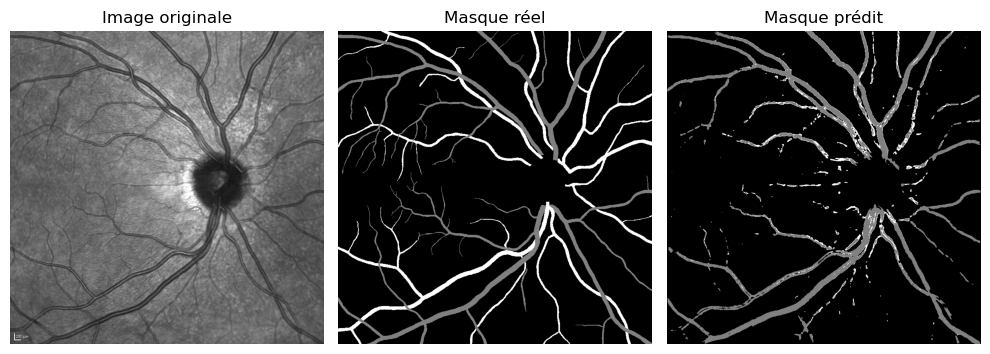

🖼️ Image 2 — Accuracy : 0.9197


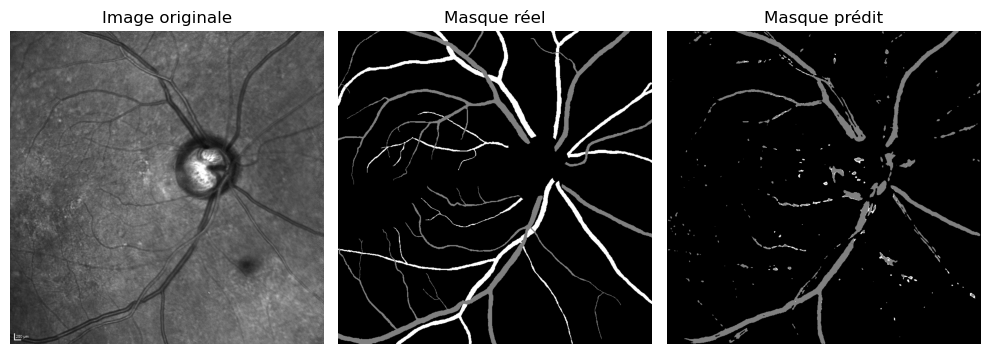

🖼️ Image 3 — Accuracy : 0.9142


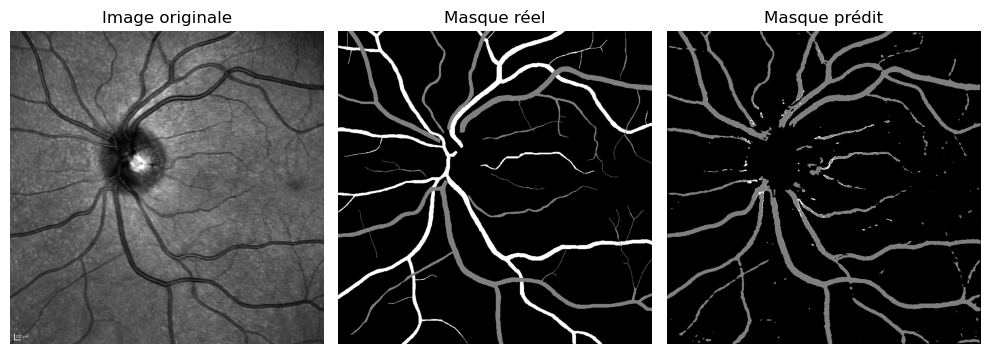

🖼️ Image 4 — Accuracy : 0.9180


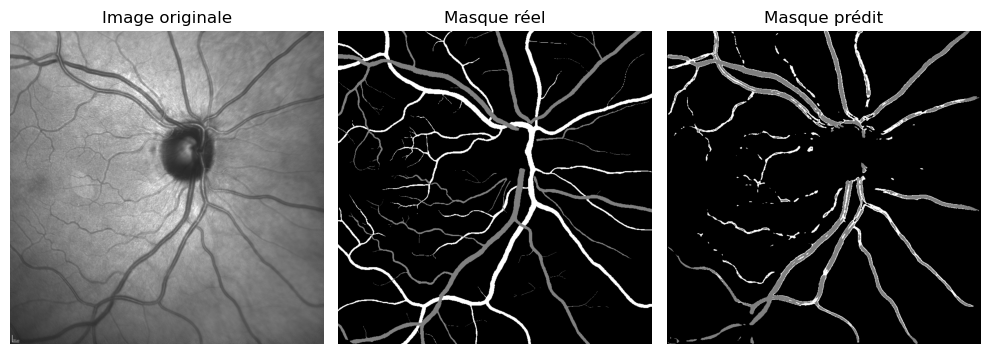

🖼️ Image 5 — Accuracy : 0.8538


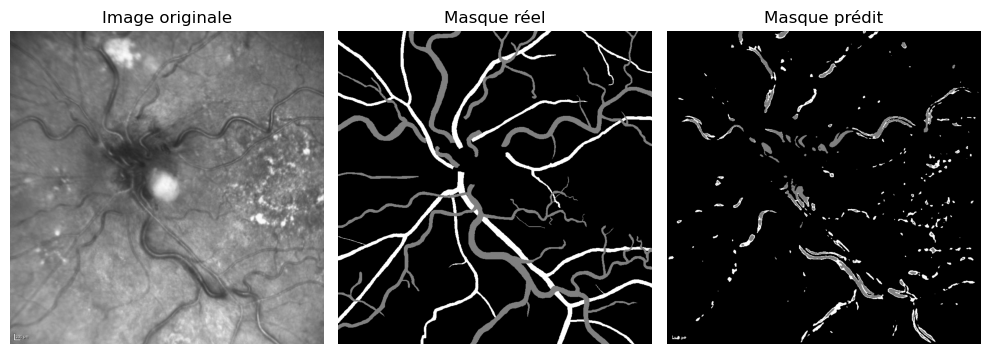


✅ Accuracy moyenne sur le jeu de validation : 0.9042


In [33]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()
total_correct = 0
total_pixels = 0

with torch.no_grad():
    img_index = 0  # compteur global des images

    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        outputs = model(imgs)
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

        # Boucle sur chaque image du batch
        for i in range(len(imgs)):
            pred = preds[i]
            mask = masks[i]

            # ===== Calcul de l’accuracy de cette image =====
            correct_pixels = (pred == mask).sum().item()
            total_pixels_img = mask.numel()
            acc_img = correct_pixels / total_pixels_img

            print(f"🖼️ Image {img_index+1} — Accuracy : {acc_img:.4f}")

            # ===== Affichage visuel =====
            fig, ax = plt.subplots(1, 3, figsize=(10, 4))
            ax[0].imshow(imgs[i].cpu().permute(1, 2, 0))
            ax[0].set_title("Image originale")
            ax[1].imshow(mask.cpu(), cmap="gray")
            ax[1].set_title("Masque réel")
            ax[2].imshow(pred.cpu(), cmap="gray")
            ax[2].set_title("Masque prédit")
            for a in ax:
                a.axis("off")
            plt.tight_layout()
            plt.show()

            # ===== Accumulateur global =====
            total_correct += correct_pixels
            total_pixels += total_pixels_img
            img_index += 1

# ===== Accuracy globale =====
val_acc = total_correct / total_pixels
print(f"\n✅ Accuracy moyenne sur le jeu de validation : {val_acc:.4f}")
